--- Generando Diagrama del Circuito ---


Matplotlib is building the font cache; this may take a moment.


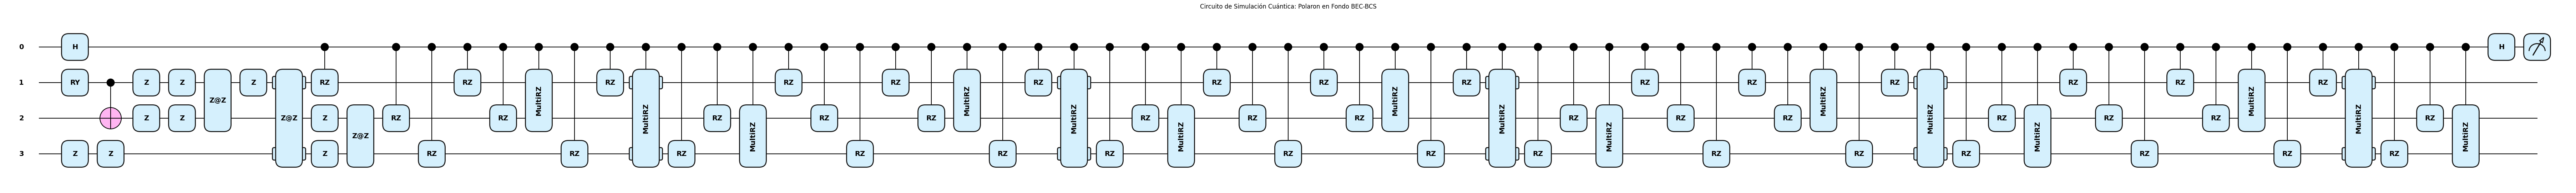


--- Iniciando Simulación Temporal (S(t)) ---
 Tiempo  P(0)_Ancilla  P(1)_Ancilla    S(t)
   0.00        1.0000        0.0000  1.0000
   0.21        0.9683        0.0317  0.9366
   0.42        0.8802        0.1198  0.7605
   0.62        0.7550        0.2450  0.5099
   0.83        0.6195        0.3805  0.2390
   1.04        0.5023        0.4977  0.0046
   1.25        0.4268        0.5732 -0.1464
   1.46        0.4057        0.5943 -0.1887
   1.67        0.4383        0.5617 -0.1235
   1.88        0.5107        0.4893  0.0215


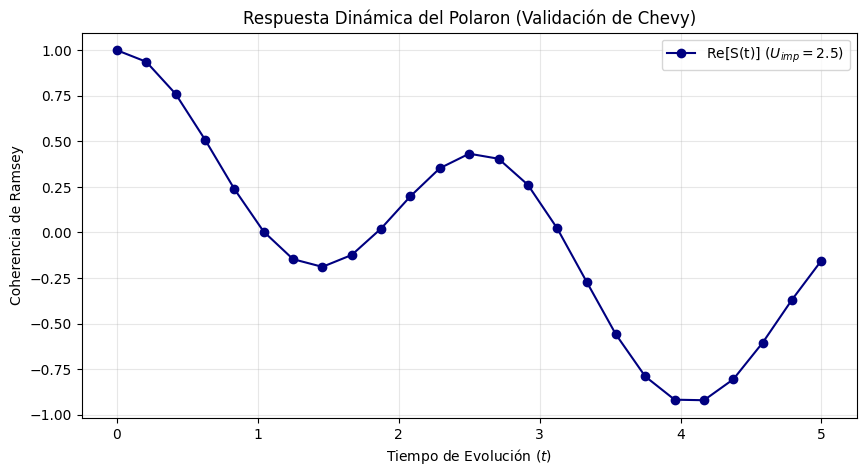


--- Generando Diagrama de Fase Espectral (Crossover) ---
Procesando U_imp = 0.10 ...
Procesando U_imp = 1.65 ...
Procesando U_imp = 3.21 ...
Procesando U_imp = 4.76 ...


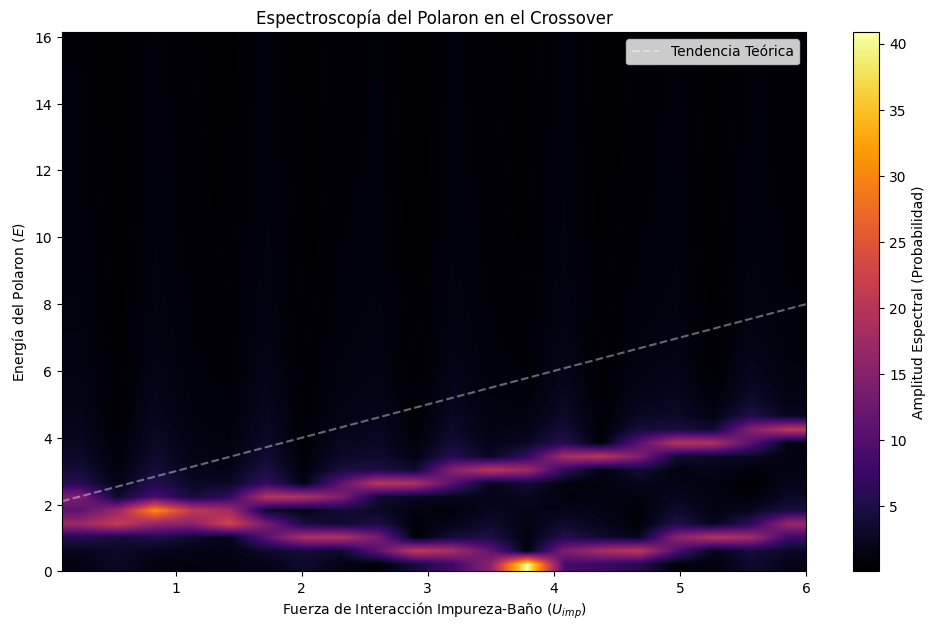

--- Simulación Completada Exitosamente ---


In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
#  SIMULACIÓN CUÁNTICA: POLARON DE FERMI EN EL CROSSOVER BEC-BCS
#  Autor: Hugo Catalá (TFG Física)
# ==============================================================================

# --- 1. CONFIGURACIÓN DEL REGISTRO CUÁNTICO ---
# Definimos los roles de cada Qubit en el procesador
ANCILLA  = 0  # Qubit Auxiliar: Controla la interferometría (Ramsey)
SYS_UP   = 1  # Baño: Modo fermiónico Espín UP
SYS_DOWN = 2  # Baño: Modo fermiónico Espín DOWN
IMPURITY = 3  # Impureza: El átomo que crea el Polaron

wires_list = [ANCILLA, SYS_UP, SYS_DOWN, IMPURITY]

# --- 2. PARÁMETROS FÍSICOS DEL MODELO ---
# Unidades naturales (J=1)
EPS_UP   = 0.5   # Energía cinética/sitio (Bath Up)
EPS_DOWN = 0.5   # Energía cinética/sitio (Bath Down)
EPS_IMP  = 0.2   # Energía cinética/sitio (Impureza)
U_FF     = 2.0   # Interacción entre fermiones del baño (Controla el gap Delta)

# Parámetros variables (Se modificarán durante el barrido)
# U_imp: Interacción Impureza-Baño (Crea el Polaron)
# Theta_BCS: Controla el régimen del baño (0=Vacío, Pi=BEC, Intermedio=BCS)

# ==============================================================================
#  MÓDULO 1: HAMILTONIANO UNIFICADO (EC. 2.35 TFG)
# ==============================================================================
def get_hamiltonian(u_imp_val):
    """
    Construye el Hamiltoniano H = H_kin + H_background + H_interaction
    Mapeado a Qubits usando Jordan-Wigner.
    """
    coeffs = []
    ops = []
    
    # A. Términos de Energía de Sitio (H_kin)
    # H ~ sum( eps * n_i ) -> -0.5 * eps * Z_i
    for w, eps in zip([SYS_UP, SYS_DOWN, IMPURITY], [EPS_UP, EPS_DOWN, EPS_IMP]):
        coeffs.append(-0.5 * eps)
        ops.append(qml.PauliZ(w))
        
    # B. Interacciones (H_int)
    # n_i * n_j -> 0.25 * (I - Z_i - Z_j + Z_i Z_j)
    # Lista de interacciones: (Qubit1, Qubit2, Fuerza)
    interactions = [
        (SYS_UP, SYS_DOWN, U_FF),       # Fondo (Pares de Cooper)
        (IMPURITY, SYS_UP, u_imp_val),  # Polaron (Spin Up)
        (IMPURITY, SYS_DOWN, u_imp_val) # Polaron (Spin Down)
    ]
    
    for w1, w2, U in interactions:
        # Correcciones a energía local (términos Z)
        c = -0.25 * U
        coeffs.append(c); ops.append(qml.PauliZ(w1))
        coeffs.append(c); ops.append(qml.PauliZ(w2))
        
        # Interacción Pura (Término ZZ)
        c_zz = 0.25 * U
        coeffs.append(c_zz); ops.append(qml.PauliZ(w1) @ qml.PauliZ(w2))
        
    return coeffs, ops

# ==============================================================================
#  MÓDULO 2: PREPARACIÓN DEL ESTADO (ANSATZ BEC-BCS)
# ==============================================================================
def prepare_bcs_background(theta):
    # 1. Superposición controlada en el primer fermión
    qml.RY(theta, wires=SYS_UP)
    # 2. Entrelazamiento con el segundo fermión (Paridad conservada)
    qml.CNOT(wires=[SYS_UP, SYS_DOWN])

# ==============================================================================
#  MÓDULO 3: CIRCUITO DE SIMULACIÓN (TROTTER + RAMSEY)
# ==============================================================================
dev = qml.device("default.qubit", wires=wires_list)

def trotter_step(coeffs, ops, dt):
    """Ejecuta un paso de tiempo e^{-iH dt} controlado por el Ancilla"""
    for c, op in zip(coeffs, ops):
        angle = 2 * c * dt
        # Controlamos la evolución física desde el Ancilla (Wire 0)
        if len(op.wires) == 1:
            qml.ctrl(qml.RZ, control=ANCILLA)(angle, wires=op.wires)
        else:
            qml.ctrl(qml.MultiRZ, control=ANCILLA)(angle, wires=op.wires)

@qml.qnode(dev)
def ramsey_circuit(time, u_imp_val, theta_bcs, steps=5):
    # 1. Inicialización del Sistema (Física del estado base)
    prepare_bcs_background(theta_bcs)
    
    # 2. Interferometría Ramsey (Inicio)
    qml.Hadamard(wires=ANCILLA)
    
    # 3. Evolución Temporal Controlada (Dinámica del Polaron)
    if time > 0:
        dt = time / steps
        # Obtenemos el Hamiltoniano para este valor de interacción
        c_curr, o_curr = get_hamiltonian(u_imp_val)
        for _ in range(steps):
            trotter_step(c_curr, o_curr, dt)
            
    # 4. Interferometría Ramsey (Cierre)
    qml.Hadamard(wires=ANCILLA)
    
    # 5. Medida
    return qml.probs(wires=ANCILLA)

# ==============================================================================
#  EJECUCIÓN 1: DIAGRAMA DEL CIRCUITO
# ==============================================================================
print("--- Generando Diagrama del Circuito ---")
fig, ax = qml.draw_mpl(ramsey_circuit, style="pennylane")(time=1.0, u_imp_val=1.5, theta_bcs=1.5)
plt.title("Circuito de Simulación Cuántica: Polaron en Fondo BEC-BCS")
plt.show() # FIGURA 1

# ==============================================================================
#  EJECUCIÓN 2: DINÁMICA TEMPORAL (TABLA Y GRÁFICA DE RAMSEY)
# ==============================================================================

print("\n--- Iniciando Simulación Temporal (S(t)) ---")
# Parámetros para esta corrida
U_IMP_TEST = 2.5
THETA_TEST = 1.57 # Pi/2 (Régimen intermedio/fuerte de pares)
t_values = np.linspace(0, 5.0, 25)

results = []
signal_St = []

for t in t_values:
    # Ejecutamos el circuito
    probs = ramsey_circuit(t, u_imp_val=U_IMP_TEST, theta_bcs=THETA_TEST, steps=8)
    
    # S(t) = P(0) - P(1)
    val = probs[0] - probs[1]
    
    # IMPORTANTE: Convertimos los tensores a float para guardarlos
    # .item() extrae el valor escalar del tensor de PennyLane
    val_num = float(val) 
    p0_num = float(probs[0])
    p1_num = float(probs[1])
    
    signal_St.append(val_num)
    
    results.append({
        "Tiempo": round(float(t), 2),
        "P(0)_Ancilla": round(p0_num, 4),
        "P(1)_Ancilla": round(p1_num, 4),
        "S(t)": round(val_num, 4)
    })

# Tabla de Datos
df = pd.DataFrame(results)
print(df.head(10).to_string(index=False)) # Mostramos primeros 10 datos

# Gráfica S(t)
plt.figure(figsize=(10, 5))
plt.plot(t_values, signal_St, 'o-', color='navy', label=f'Re[S(t)] ($U_{{imp}}={U_IMP_TEST}$)')
plt.xlabel("Tiempo de Evolución ($t$)")
plt.ylabel("Coherencia de Ramsey")
plt.title("Respuesta Dinámica del Polaron (Validación de Chevy)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show() # FIGURA 2


# ==============================================================================
#  EJECUCIÓN 3: DIAGRAMA DE FASE ESPECTRAL (MONEY PLOT)
# ==============================================================================
print("\n--- Generando Diagrama de Fase Espectral (Crossover) ---")
# Barrido de parámetros
u_imp_sweep = np.linspace(0.1, 6.0, 20) # Eje X: Fuerza de interacción
time_points = np.linspace(0, 15.0, 80)  # Tiempo largo para buena FFT
dt = time_points[1] - time_points[0]

spectral_map = []

for idx, u_val in enumerate(u_imp_sweep):
    # Simulamos la evolución temporal para este U_imp
    sig_temp = []
    for t in time_points:
        p = ramsey_circuit(t, u_imp_val=u_val, theta_bcs=1.57, steps=4)
        sig_temp.append(p[0] - p[1])
    
    # FFT para obtener espectro de energía
    fft_vals = np.abs(np.fft.fft(sig_temp))
    freqs = np.fft.fftfreq(len(sig_temp), d=dt)
    
    # Filtramos solo frecuencias positivas (Energías)
    pos_mask = freqs >= 0
    spectral_map.append(fft_vals[pos_mask])
    
    if idx % 5 == 0: print(f"Procesando U_imp = {u_val:.2f} ...")

# Transponer para plotear (X=U_imp, Y=Energía)
spectral_map = np.array(spectral_map).T
energies = 2 * np.pi * freqs[pos_mask]

# Gráfica Heatmap
plt.figure(figsize=(12, 7))
plt.imshow(
    spectral_map, 
    aspect='auto', 
    origin='lower',
    extent=[min(u_imp_sweep), max(u_imp_sweep), min(energies), max(energies)],
    cmap='inferno', interpolation='bilinear'
)
plt.colorbar(label='Amplitud Espectral (Probabilidad)')
plt.xlabel('Fuerza de Interacción Impureza-Baño ($U_{imp}$)')
plt.ylabel('Energía del Polaron ($E$)')
plt.title('Espectroscopía del Polaron en el Crossover')
# Línea guía teórica (Aprox)
plt.plot(u_imp_sweep, 2*EPS_UP + u_imp_sweep + 1.0, 'w--', alpha=0.4, label='Tendencia Teórica')
plt.legend()
plt.show() # FIGURA 3

print("--- Simulación Completada Exitosamente ---")